In [1]:
import numpy as np
import astropy
import math
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import matplotlib
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from scipy.stats import norm
from scipy.ndimage import shift
from scipy.optimize import curve_fit

In [2]:
#Import the cropped image of the target
image_JWST = get_pkg_data_filename("/content/SPT2147-50_JWST_560w_target_crop.fits") # Adapted from https://learn.astropy.org/tutorials/FITS-images.html

In [3]:
fits.info(image_JWST) # See some metadata about the target, including shape

Filename: /content/SPT2147-50_JWST_560w_target_crop.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU      65   (89, 89)   float32   


In [4]:
image_data_JWST = fits.getdata(image_JWST, ext=0) # Create an array of data

In [6]:
header_JWST = fits.open(image_JWST) # Adapted from https://docs.astropy.org/en/stable/io/fits/index.html
t_exp_JWST = header_JWST[0].header['XPOSURE'] # Exposure time in seconds
print(t_exp_JWST)

99.9


In [7]:
image_data_JWST_cps = image_data_JWST/header_JWST[0].header['PHOTMJSR']

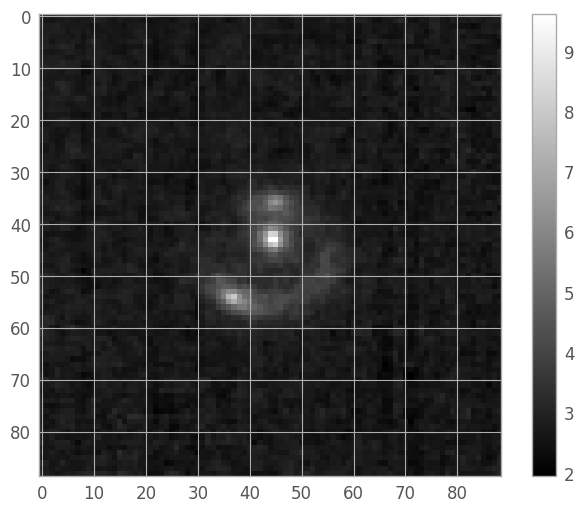

In [8]:
plt.figure() # Make a plot of target (for visual inspection or inclusion in final report)
plt.imshow(image_data_JWST_cps, cmap = 'gray') # Can use origin = 'lower' to change position of (0,0), see https://openastronomy.org/rcsc18/chapters/12-images-and-visualisation/01-images
plt.colorbar()

2.7158048
0.20974804


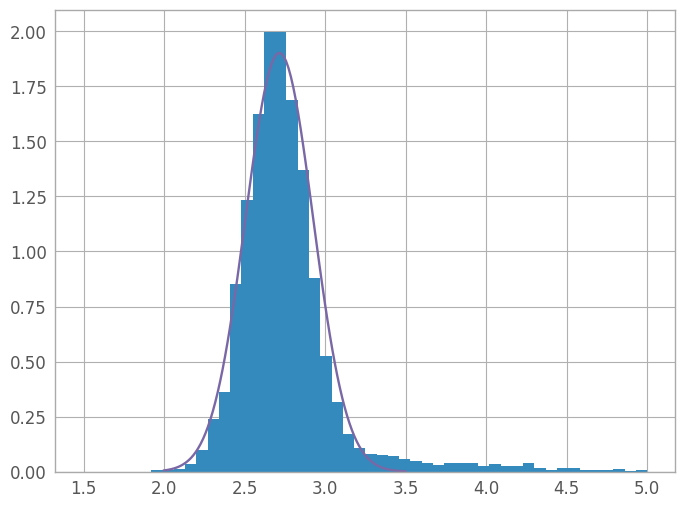

In [10]:
# https://machinelearningmastery.com/how-to-transform-data-to-fit-the-normal-distribution/
# Make a histogram of all the pixel values in the image and fit an unweighted Gaussian to it
histogram_JWST = plt.hist(image_data_JWST_cps.flatten(), range = [1.5,5], bins = 50,density = True)
image_data_JWST_trim = [y for y in image_data_JWST_cps.flatten() if 2 < y < 3.5]

(mu,sigma) = norm.fit(image_data_JWST_trim)
xmin,xmax = (2,3.5)
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x,p)

print(mu) # In units of cps
print(sigma) # In units of cps

In [11]:
def gauss_f(xe,mue,sige):
    return (1/(sige*(np.sqrt(2*np.pi))))*np.exp((-1/2)*(((xe-mue)**2)/(sige**2)))

In [12]:
#We want to only fit the region which displays Gaussian behavior
image_data_JWST_trim_wt = [y for y in image_data_JWST_cps.flatten() if 2 < y < 3.5]

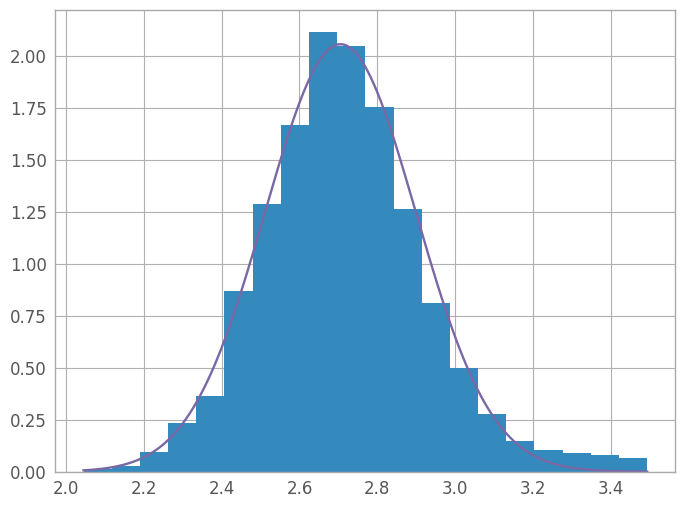

2.705235702811191
0.19407550863934026


In [13]:
# Now make fit a weighted Gaussian to the same histogram, using the results of the unweighted fit as an initial guess
n, bins, _ = plt.hist(image_data_JWST_trim_wt, 20, density=True) # This code provided by Ruthvik Joshi
centerofbins = np.zeros([len(bins) - 1])
errorsinbins = np.zeros([len(bins) - 1])
for i in range(len(bins)-1):
    centerofbins[i] = (bins[i]+bins[i+1])/2
    errorsinbins[i] = np.sqrt(n[i])
popt, pcov = curve_fit(gauss_f, centerofbins, n,sigma=errorsinbins, p0=[mu, sigma])
mu_wt, sig_wt = popt
x_model = np.linspace(min(bins), max(bins), 1000)
y_model = gauss_f(x_model, mu_wt, sig_wt)
plt.plot(x_model, y_model)
plt.show()

print(mu_wt) # In units of cps
print(sig_wt) # In units of cps

In [14]:
# Sigma sky unweighted w exposure time
sigma_sky_JWST = sigma*t_exp_JWST
sigma_sky_JWST**2 # In units of counts**2


439.0629772753517

In [15]:
# Sigma sky weighted w exposure time
sigma_sky_wt_JWST = sig_wt*t_exp_JWST
sigma_sky_wt_JWST_2 = sigma_sky_wt_JWST**2 #In units of counts**2
sigma_sky_wt_JWST_2

375.9001011281445

In [16]:
# Background subtract
image_data_JWST_bkg = image_data_JWST_cps - mu_wt

In [32]:
# Determine the Poisson noise
sigma_p_JWST_2 = t_exp_JWST*image_data_JWST_bkg # In units of counts**2
sigma_p_JWST_2

array([[-22.768261 , -10.81488  , -16.494453 , ..., -27.128387 ,
          5.4440603,   4.1797285],
       [ 15.249723 ,  -4.210835 , -16.820402 , ...,   8.686145 ,
         17.023428 ,  13.842197 ],
       [ 21.915648 ,  16.066467 ,  18.888401 , ...,   7.2991266,
         -5.4102387,  -6.0262914],
       ...,
       [ 23.307669 ,  21.890615 , -13.885571 , ..., -25.588505 ,
         -1.2599255,  30.302233 ],
       [ -9.532185 ,  10.664993 , -11.343497 , ...,  12.22374  ,
         35.0374   ,  26.553087 ],
       [ 19.67111  ,  20.029047 ,   3.8900776, ..., -10.935161 ,
          9.186156 ,  32.19946  ]], dtype=float32)

In [33]:
sig_tot_JWST_2 = sigma_p_JWST_2 + sigma_sky_wt_JWST_2

In [34]:
sigma_tot_JWST = np.sqrt(sig_tot_JWST_2)/t_exp_JWST #in cps

In [35]:
sigma_tot_JWST_flux = sigma_tot_JWST*header_JWST[0].header['PHOTMJSR']

In [36]:
sigma_tot_JWST_flux

array([[0.10898004, 0.11080915, 0.10994386, ..., 0.10830515, 0.1132497 ,
        0.11306181],
       [0.11469647, 0.11180688, 0.10989399, ..., 0.11373009, 0.11495624,
        0.11448993],
       [0.11566968, 0.11481616, 0.11522873, ..., 0.11352482, 0.11162633,
        0.11153349],
       ...,
       [0.11587187, 0.11566603, 0.11034217, ..., 0.10854399, 0.11224983,
        0.11688257],
       [0.11100364, 0.11402231, 0.1107289 , ..., 0.11425196, 0.11756184,
        0.11634192],
       [0.1153429 , 0.11539507, 0.11301871, ..., 0.1107909 , 0.113804  ,
        0.11715521]], dtype=float32)

In [ ]:
  n_map = fits.PrimaryHDU(sigma_tot_JWST)
  n_map.writeto('JWSTNoiseMap50_560w.fits', overwrite = True)

In [ ]:
target_bkg = fits.PrimaryHDU(image_data_JWST_bkg)
target_bkg.writeto('SPT2147-50_JWST_560w_target_crop_bkg.fits', overwrite = True)

Determining the empirical Point Spread Function using images of two stars

In [37]:
image_JWST_psf_1 = get_pkg_data_filename("/content/SPT2147-50_JWST_560w_psf1.fits") # Import data from first selected star for PSF

In [38]:
image_data_JWST_psf_1 = fits.getdata(image_JWST_psf_1, ext = 0) # Create an array from the imported data

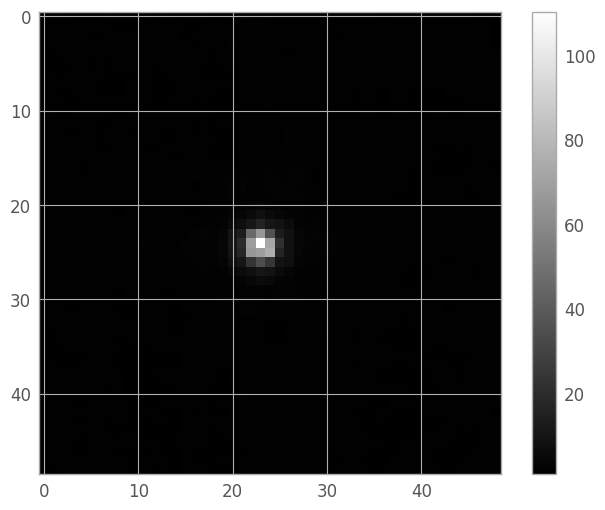

In [39]:
plt.figure() # Make a plot of the star being used for first PSF input
plt.imshow(image_data_JWST_psf_1, cmap = 'gray')
plt.colorbar()

In [40]:
np.shape(image_data_JWST_psf_1) # The center of the array is located at (n-1, n-1) since we start indexing at 0

(49, 49)

In [41]:
max_pos_psf_1 = np.where(image_data_JWST_psf_1==np.max(image_data_JWST_psf_1))
max_pos_psf_1 # If the max value occurs more than once, the image could be saturated and therefore unusable

(array([24]), array([23]))

In [42]:
# Subtract the background from the PSF 1 file
image_data_JWST_psf_1_bkg = image_data_JWST_psf_1 - mu_wt
image_data_JWST_psf_1_bkg

array([[-0.9142636 , -1.1298555 , -1.1509751 , ..., -1.2862076 ,
        -1.2797445 , -1.2813888 ],
       [-0.8452518 , -0.93354595, -1.0857656 , ..., -1.1533513 ,
        -1.181502  , -1.2549695 ],
       [-0.9433428 , -1.0037882 , -1.1651827 , ..., -1.1053499 ,
        -1.2090071 , -1.3229047 ],
       ...,
       [-1.0858833 , -1.0435079 , -1.00113   , ..., -1.1628691 ,
        -1.008411  , -1.0056705 ],
       [-1.2901542 , -1.1752348 , -0.91963804, ..., -0.92381537,
        -0.90921307, -1.0655385 ],
       [-1.1924921 , -1.2362745 , -1.0410792 , ..., -0.9984716 ,
        -1.1095217 , -1.0882633 ]], dtype=float32)

In [43]:
image_data_JWST_psf_1_norm = image_data_JWST_psf_1_bkg/np.max(image_data_JWST_psf_1_bkg) # Normalize the data to the max value

In [44]:
image_data_JWST_psf_1_norm_ctr = shift(image_data_JWST_psf_1_norm,(0,1), cval = np.NaN)
# As shown above, the max value is not in the center of the array. We need to shift it.

In [45]:
np.where(image_data_JWST_psf_1_norm_ctr==1) # Verify the shift was done correctly.

(array([24]), array([24]))

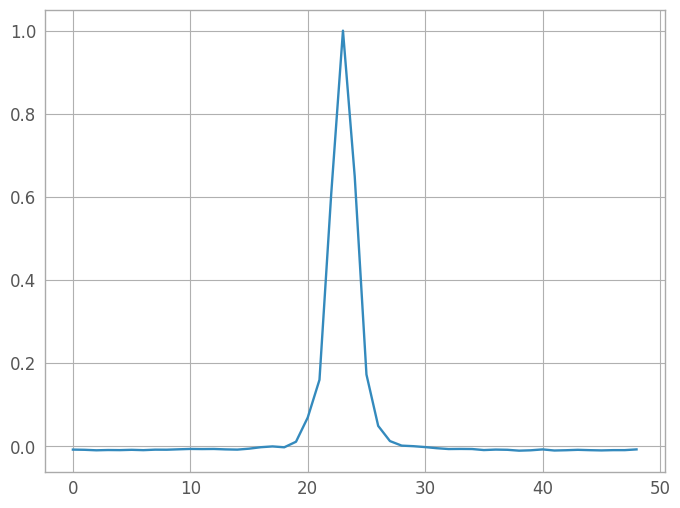

In [46]:
plt.plot(image_data_JWST_psf_1_norm[24]) # Plot this array, not _ctr, since _ctr will have Nans at edge

Text(0.5, 0.5, 'Pixel')

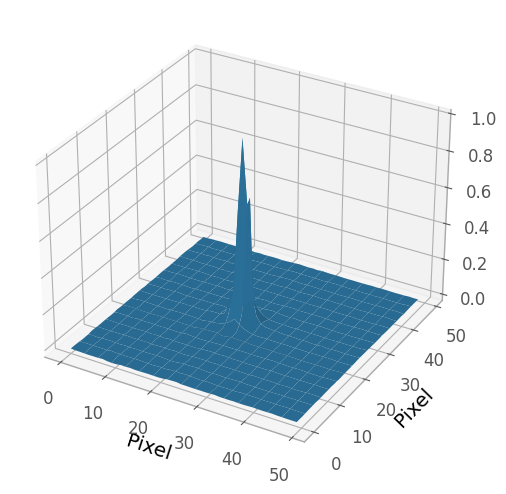

In [80]:
x_2d_psf_1 = np.linspace(0,49,49) # Make a 2D plot for this PSF input. Some code adpated from https://stackoverflow.com/questions/19280818/3d-plots-in-python
y_2d_psf_1 = np.linspace(0,49,49)
x_2d_psf_1, y_2d_psf_1 = np.meshgrid(x_2d_psf_1, y_2d_psf_1)
fig_2d_psf_1 = plt.figure()
ax1_psf_1 = fig_2d_psf_1.add_subplot(projection = '3d')

ax1_psf_1.plot_surface(x_2d_psf_1, y_2d_psf_1, image_data_JWST_psf_1_norm,rstride = 3, cstride = 3, linewidth = 1, antialiased = True)
plt.xlabel('Pixel')
plt.ylabel('Pixel')


In [ ]:
#with np.printoptions(threshold=np.inf): # Verify the location of the Nan values which resulted from shifting
    #print(image_data_560w_psf_1_norm_ctr)

In [50]:
image_JWST_psf_2 = get_pkg_data_filename("/content/SPT2147-50_JWST_560w_psf2.fits") # Import data for the second input for the PSF

In [51]:
image_data_JWST_psf_2 = fits.getdata(image_JWST_psf_2, ext = 0) # Make an array from this data

In [52]:
np.shape(image_data_JWST_psf_2) # Determine shape of the array

(51, 51)

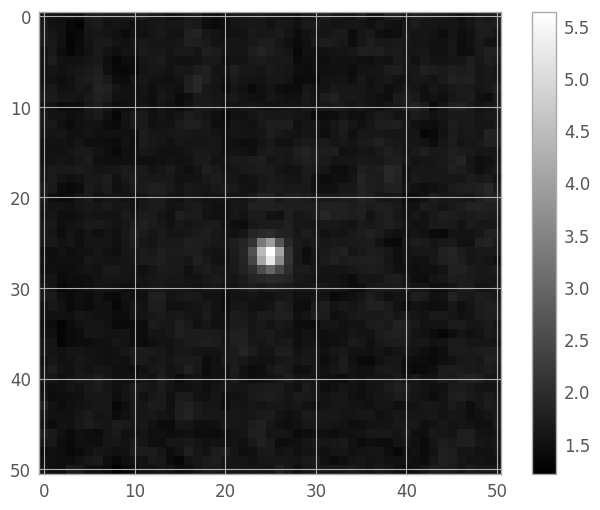

In [53]:
plt.figure() # Make a plot
plt.imshow(image_data_JWST_psf_2, cmap = 'gray')
plt.colorbar()

In [54]:
max_pos_psf_2 = np.where(image_data_JWST_psf_2==np.max(image_data_JWST_psf_2))
max_pos_psf_2 # Check to see if this star is saturated and if max is near center.

(array([26]), array([25]))

In [55]:
image_data_JWST_psf_2_bkg = image_data_JWST_psf_2 - mu_wt #Background subtract

In [56]:
image_data_JWST_psf_2_norm = image_data_JWST_psf_2_bkg/np.max(image_data_JWST_psf_2_bkg) #Normalize the data

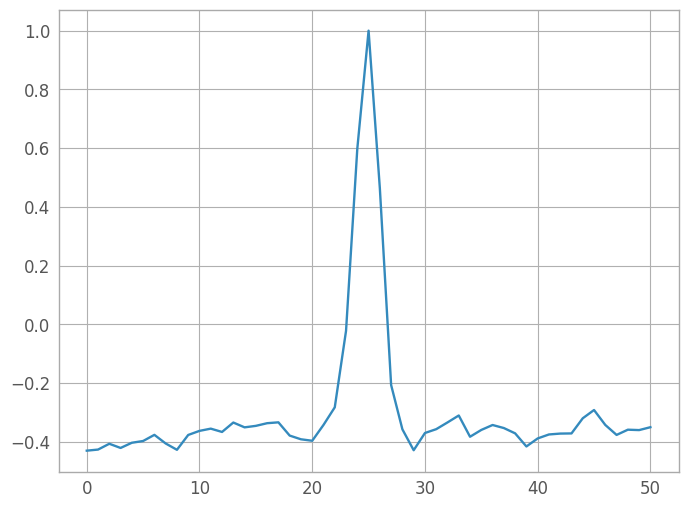

In [57]:
plt.plot(image_data_JWST_psf_2_norm[26]) # Make a plot of one "slice" of the data

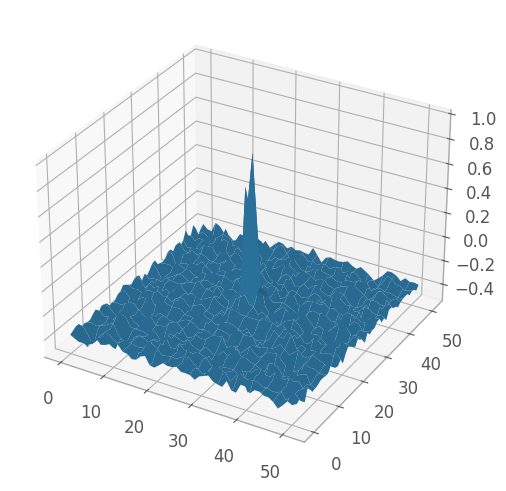

In [58]:
x_2d_psf_2 = np.linspace(0,51,51)
y_2d_psf_2 = np.linspace(0,51,51)
x_2d_psf_2, y_2d_psf_2 = np.meshgrid(x_2d_psf_2, y_2d_psf_2)
fig_2d_psf_2 = plt.figure()
ax1_psf_2 = fig_2d_psf_2.add_subplot(projection = '3d')

ax1_psf_2.plot_surface(x_2d_psf_2, y_2d_psf_2, image_data_JWST_psf_2_norm,rstride = 3, cstride = 3, linewidth = 1, antialiased = True)

In [59]:
image_data_JWST_psf_2_norm[26,25] # Confirming location of max value in array

1.0

In [60]:
np.shape(image_data_JWST_psf_2_norm) # Reconfirm array is square and odd number of pixels

(51, 51)

In [ ]:
#type(image_data_560w_psf_2_norm_slice_square)

In [ ]:
#max_pos_psf_2 = np.where(image_data_560w_psf_2_norm_slice_square==np.max(image_data_560w_psf_2_norm_slice_square))
#max_pos_psf_2

In [61]:
image_data_JWST_psf_2_norm_ctr = shift(image_data_JWST_psf_2_norm,(-1,0), cval = np.NaN)

In [62]:
max_pos_psf_2 = np.where(image_data_JWST_psf_2_norm_ctr==1)
max_pos_psf_2 # The max value is in the center now.

(array([25]), array([25]))

In [63]:
sliced_psf_2 = slice(2,49) # Get rid of Nans, while keeping array square
image_data_JWST_psf_2_nanrows = image_data_JWST_psf_2_norm_ctr[sliced_psf_2]
np.shape(image_data_JWST_psf_2_nanrows)

(47, 51)

In [64]:
image_data_JWST_psf_2_mod = [] # Need to make square
for i in image_data_JWST_psf_2_nanrows:
  if len(i) > 31:
    i = i[2:-2]
  image_data_JWST_psf_2_mod.append(i)

In [65]:
np.shape(image_data_JWST_psf_2_mod) # The array is square again

(47, 47)

In [66]:
image_data_JWST_psf_2_final = np.reshape(image_data_JWST_psf_2_mod, (47,47))
np.where(image_data_JWST_psf_2_final==1)

(array([23]), array([23]))

In [67]:
np.shape(image_data_JWST_psf_1_norm_ctr)

(49, 49)

In [68]:
sliced_psf_1 = slice(1,48) # Make the larger PSF the same size as the smaller
image_data_JWST_psf_1_resize = image_data_JWST_psf_1_norm_ctr[sliced_psf_1]
np.shape(image_data_JWST_psf_1_resize)

(47, 49)

In [69]:
image_data_JWST_psf_1_mod = [] # Need to make square
for i in image_data_JWST_psf_1_resize:
  if len(i) > 30:
    i = i[1:-1]
  image_data_JWST_psf_1_mod.append(i)

In [70]:
np.shape(image_data_JWST_psf_1_mod) # The larger PSF is now the same size

(47, 47)

In [71]:
image_data_psf_1_final = np.reshape(image_data_JWST_psf_1_mod, (47,47))

In [72]:
np.where(image_data_psf_1_final==1)

(array([23]), array([23]))

In [73]:
# Code adpated from https://stackoverflow.com/questions/13753251/median-combining-fits-images-in-python
psf_JWST_combined = np.array([image_data_psf_1_final,image_data_JWST_psf_2_final])

In [74]:
psf_JWST_final = np.median(psf_JWST_combined, axis = 0) #Median combine images, code adapted from https://stackoverflow.com/questions/31713637/stacking-star-psfs-from-an-image-aligning-sub-pixel-centers

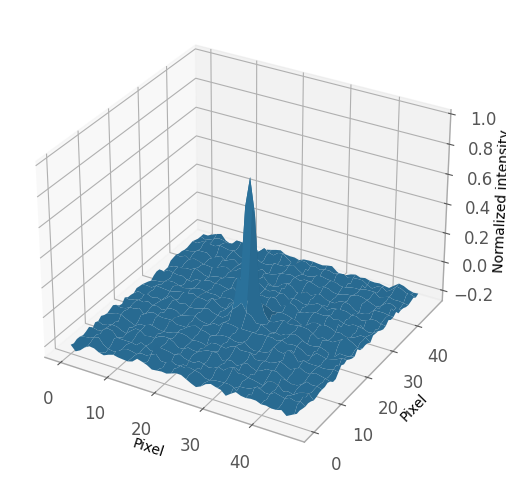

In [94]:
x_2d_psf_final = np.linspace(0,47,47)
y_2d_psf_final = np.linspace(0,47,47)
x_2d_psf_final, y_2d_psf_final = np.meshgrid(x_2d_psf_final, y_2d_psf_final)
fig_2d_psf_final = plt.figure()
ax1_psf_final = fig_2d_psf_final.add_subplot(projection = '3d')
axl=fig_2d_psf_final.gca()
plt.xlabel('Pixel', fontsize = 10)
plt.ylabel ('Pixel', fontsize = 10)
axl.set_zlabel('Normalized intensity', fontsize = 10)

ax1_psf_final.plot_surface(x_2d_psf_final, y_2d_psf_final, psf_JWST_final,rstride = 3, cstride = 3, linewidth = 1, antialiased = True)

In [76]:
np.max(psf_JWST_final)

1.0

Text(0, 0.5, 'Pixel')

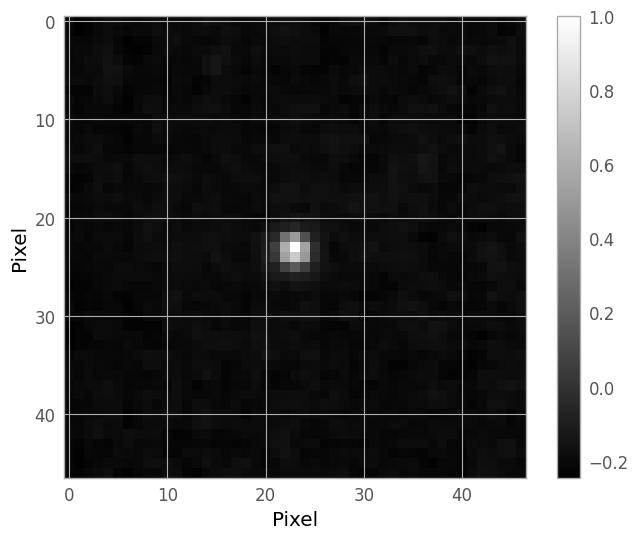

In [78]:
plt.figure() # Make a plot
plt.imshow(psf_JWST_final, cmap = 'gray')
plt.colorbar()
plt.xlabel('Pixel')
plt.ylabel('Pixel')

In [ ]:
psfJWST = fits.PrimaryHDU(psf_JWST_final)
psfJWST.writeto("JWST_560w_PSFfile_Bkg.fits", overwrite = True)